In [2]:
from fastai.vision.all import *

In [3]:
PATH = Path('../input/optiver-realized-volatility-prediction')

# data_df = pd.read_parquet(PATH/'book_train_reindexed.parquet')

# sizes = ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']
# for sz in sizes:
#     data_df[sz] = data_df[sz]/ 1_000_000



In [27]:
#train_df = pd.read_csv(PATH/'train_with_offset.csv')
# data_df['wap'] = (data_df.bid_price1 * data_df.ask_size1 + data_df.ask_price1 * data_df.bid_size1) / (data_df.ask_size1 + data_df.bid_size1)

# mean_wap =[]
# for row in train_df.itertuples():
#     df = data_df.iloc[row.offset:row.offset+600]
#     mean_wap.append(df.wap.mean())

In [28]:
# train_df['mean_wap']=mean_wap
# train_df.to_csv(PATH/'train_with_wap.csv')

In [29]:
# np_data = data_df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()

# del data_df

# np_data = np_data.astype('float32')
# torch_data = torch.tensor(np_data)

# del np_data

# torch.save(torch_data, PATH/'torch_data.pth')

In [4]:
%%time
torch_data = torch.load(PATH/'torch_data.pth')

CPU times: user 0 ns, sys: 11.2 s, total: 11.2 s
Wall time: 2min 2s


In [31]:
#torch_data[:,[2,3,6,7]] = 1000000 * torch_data[:,[2,3,6,7]] 

In [5]:
means, stds = torch_data.mean(dim=0), torch_data.std(dim=0)
print(means, stds)
torch_data = (torch_data - means) / stds

tensor([9.9968e-01, 1.0003e+00, 7.6999e-04, 7.6673e-04, 9.9948e-01, 1.0005e+00,
        9.5934e-04, 9.2822e-04]) tensor([0.0037, 0.0037, 0.0054, 0.0050, 0.0037, 0.0037, 0.0067, 0.0057])


In [6]:
train_df = pd.read_csv(PATH/'train_with_wap.csv')

In [7]:
w = train_df.mean_wap.to_numpy()

w =np.sort(w)

bins = []

step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 2)
    print(w[i], w[j-1],np.median(w[i:j]) )

wap_bin = np.digitize(train_df.mean_wap, bins)

train_df['wap_bin']=wap_bin

0.9172531180048944 0.9971951138775056 0.9956492523836432
0.9971951327900604 0.9984703256953886 0.9979708959569917
0.9984703751656142 0.9991431543863876 0.9988451162091514
0.9991431683337992 0.999616836138266 0.9993924853218963
0.9996168497680276 1.0000141933324718 0.9998199779860442
1.0000141975255898 1.0004091980748968 1.00020793857736
1.0004091986325243 1.000876884050013 1.0006291062379966
1.0008769297217603 1.0015230362748495 1.0011664016312456
1.0015230933064834 1.002768629281105 1.0020189286622183
1.0027686365447124 1.077264872305151 1.004330146304397


In [8]:
w = train_df.target.to_numpy()

w =np.sort(w)

bins = []
bin_med=[]
step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 1)
    bin_med.append(np.median(w[i:j]))
    print(w[i], w[j-1],np.median(w[i:j]) )

target_bin = np.digitize(train_df.target, bins)

train_df['target_bin']=target_bin

0.000105263 0.001436988 0.001175852
0.001436991 0.001838282 0.0016455530000000001
0.001838308 0.002210492 0.0020263215
0.002210493 0.002604845 0.00240206
0.002604847 0.003048064 0.002817908
0.003048071 0.003585089 0.0033027735
0.003585105 0.00428704 0.003905317
0.004287042 0.005311553 0.0047378975
0.005311559 0.007240946 0.0060829544999999995
0.007240976 0.07032062 0.009453786499999998


In [115]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size = (5,1), padding = (2,0), padding_mode='replicate'),
            nn.BatchNorm2d(ch),
            nn.ReLU(),
            #nn.Dropout(p=.25),
            nn.Conv2d(ch, ch, kernel_size = (5,1), padding = (2,0), padding_mode='replicate'),
            nn.BatchNorm2d(ch),
#             nn.ReLU(),
#             nn.Dropout(p=.25)
        )
        
    def forward(self, x):
        res = self.layers(x) + x
        res = F.relu(res)
        #res = F.dropout(res, p=.25)
        return res

In [206]:
LinBnDrop(10,5, p=.5)

LinBnDrop(
  (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=10, out_features=5, bias=False)
)

In [235]:
class ResnetModel(nn.Module):
    def __init__(self, num_outputs, chan = 16, do_sigmoid = False):
        super().__init__()
        self.do_sigmoid = do_sigmoid
        layers = [
            nn.Conv2d(1,chan, kernel_size=(5,8), padding=(2,0)),
            nn.BatchNorm2d(chan),
            nn.ReLU()
        ]
        for _ in range(7):
            layers += [ResBlock(chan), ResBlock(chan),ResBlock(chan)
                       , nn.MaxPool2d((2,1), padding=(1,0))]
            
        layers += [Flatten(), nn.Dropout()]
        
        self.conv_layers = nn.Sequential(*layers)
        self.embeddings = nn.Embedding(127,32)
        self.classifier = nn.Sequential(
            LinBnDrop(128,32, p=.5, act=nn.ReLU()),
            LinBnDrop(32, num_outputs)
        )
        
        
    def forward(self, x, stock_id):
        emb = self.embeddings(stock_id)
        feat =  self.conv_layers(x)
        con_feat = torch.cat([emb, feat], dim=1)
        #print(emb.shape, feat.shape, con_feat.shape)
        res = self.classifier(con_feat)
        if self.do_sigmoid:
            res = sigmoid_range(res, 0, .1).view(-1)
        return res

In [103]:
class ResnetRegression(nn.Module):
    def __init__(self, stem, num_inputs):
        super().__init__()
        self.stem = stem
        self.classifier = nn.Sequential(
            nn.Linear(num_inputs, 1),
            SigmoidRange(0,.1)
        )
        
    def forward(self, x):
        return self.classifier(self.stem(x)).view(-1)

In [199]:
train_df.stock_id.max()

126

In [187]:
def stock_id(row):
    return row.stock_id

In [188]:
class LoadTransform(Transform):
    def __init__(self, torch_data):
        super().__init__()
        self.data = torch_data
        
    def encodes(self, row):
        #df = self.data.iloc[row.offset:row.offset+600]
        #ret = df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()
        #ret = ret.reshape(1,600,8).astype('float32')
        ret = self.data[row.offset:row.offset+600]
        return ret.view(1,600,8)

tfm = LoadTransform(torch_data)

data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  TransformBlock(type_tfms=stock_id),
                  CategoryBlock(vocab=list(range(10)))),
        splitter=ColSplitter(),
        #get_y=ColReader('target'),
        #get_y=ColReader('wap_bin'),
        get_y=ColReader('target_bin'),
)
dls = data_block.dataloaders(train_df, bs=1024)

In [189]:
b = dls.one_batch()

In [190]:
b[1]

tensor([88, 29,  2,  ..., 53, 60, 50], device='cuda:0')

In [232]:
dls_reg = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  TransformBlock(type_tfms=stock_id),
                  RegressionBlock()),
        splitter=ColSplitter(),
        get_y=ColReader('target'),
).dataloaders(train_df, bs = 1024)


In [223]:
b1,b2,by = dls.one_batch()

In [224]:
ResnetModel(10).cuda()(b1,b2).shape

torch.Size([1024, 10])

In [65]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [66]:
def mspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean()

In [67]:
def my_mse_loss(preds, targs):
    x = (targs-preds)
    #res = ((x**2)/(targs**2))
    res = (x/targs) ** 2
    return res.sqrt().mean()

In [68]:
def rmspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [225]:
#learn = Learner(dls, ConvModel(),loss_func=mspe_loss, metrics=AccumMetric(rmspe))
learn = Learner(dls, ResnetModel(10), metrics = [accuracy])#, cbs=MixUp)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.010964781977236271)

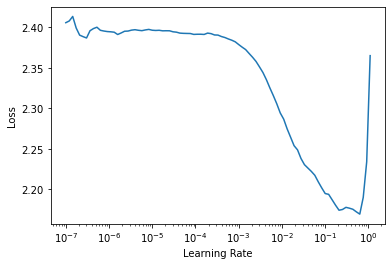

In [217]:
learn.lr_find()

In [226]:
learn.fit_one_cycle(12,1e-3, wd=.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.949335,1.768853,0.312271,00:43
1,1.572961,1.535390,0.370810,00:44
2,1.518479,1.466972,0.402330,00:44
3,1.487304,1.795147,0.291742,00:44
4,1.472659,1.457969,0.400707,00:44
5,1.455172,1.479894,0.390754,00:44
6,1.440178,1.450203,0.400329,00:45
7,1.437704,1.448367,0.404769,00:44
8,1.429211,1.460592,0.395853,00:44
9,1.417100,1.469772,0.393523,00:44


In [153]:
learn.save('res_model2.pth')

Path('models/res_model2.pth.pth')

In [237]:
#learn.load('res_model2.pth')

#stem = nn.Sequential(*list(learn.model.layers.children())[:-1])
#stem = nn.Sequential(*list(ResnetModel(10).layers.children())[:-1])
#reg_m = ResnetRegression(stem, 6*16)
reg_m = ResnetModel(1, do_sigmoid=True)
learn2 = Learner(dls_reg, reg_m, loss_func=my_mse_loss, metrics=AccumMetric(rmspe), wd=.1)

In [238]:
bx1,bx2,by=dls_reg.one_batch()
out = reg_m.cuda()(bx1,bx2)
F.mse_loss(out, by), my_mse_loss(out, by)

(tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(18.4136, device='cuda:0', grad_fn=<MeanBackward0>))

In [158]:
learn2.fine_tune(8, 5e-3,freeze_epochs=3)

epoch,train_loss,valid_loss,rmspe,time
0,0.525847,0.279563,0.330532,00:33
1,0.410391,0.221905,0.280816,00:33
2,0.341766,0.239141,0.290424,00:33


epoch,train_loss,valid_loss,rmspe,time
0,0.303880,0.216230,0.265960,00:33
1,0.284530,0.204399,0.263012,00:33
2,0.258509,0.219640,0.286061,00:33
3,0.243210,0.208284,0.282748,00:33
4,0.230162,0.215831,0.289757,00:33
5,0.223162,0.204588,0.270721,00:33
6,0.218093,0.217212,0.271917,00:32
7,0.217493,0.199908,0.257180,00:33


In [239]:
learn2.fit_flat_cos(12, 1e-3, wd=.2)

epoch,train_loss,valid_loss,rmspe,time
0,1.752117,1.559247,2.350907,00:42
1,0.434702,0.428289,0.714543,00:42
2,0.318538,0.297535,0.430545,00:41
3,0.263533,0.278086,0.488064,00:42
4,0.288248,0.353670,5.214664,00:43
5,0.232106,0.215500,0.300030,00:43
6,0.221665,0.213563,0.296188,00:42
7,0.215383,0.229248,0.311769,00:43
8,0.212203,0.218769,0.321531,00:43
9,0.208908,0.224181,0.316923,00:43


In [135]:
torch.save(learn2.model, 'res248.pth')

In [58]:
preds, targs = learn2.get_preds()

rmspe(preds.view(-1), targs)

tensor(0.2498)

In [169]:
preds, targs = learn.get_preds()

In [170]:
predicted_bins = torch.argmax(preds, dim=1)

In [171]:
CI = ClassificationInterpretation.from_learner(learn)

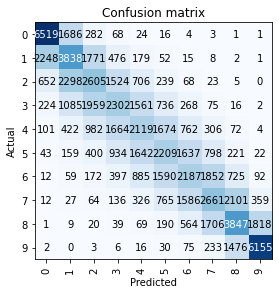

In [172]:
CI.plot_confusion_matrix()

In [173]:
pred_vals =torch.tensor(bin_med)[predicted_bins]

In [174]:
target_vals = dls.valid.items.target.to_numpy()
target_vals = torch.tensor(target_vals)

In [175]:
pred_vals[:10], target_vals[:10]

(tensor([0.0039, 0.0020, 0.0016, 0.0028, 0.0047, 0.0033, 0.0020, 0.0095, 0.0039,
         0.0047], dtype=torch.float64),
 tensor([0.0037, 0.0018, 0.0021, 0.0021, 0.0040, 0.0032, 0.0030, 0.0135, 0.0037,
         0.0054], dtype=torch.float64))

In [176]:
rmspe(pred_vals, target_vals)

tensor(0.3144, dtype=torch.float64)